In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random 
import mfmodel as mfm

from scipy.linalg import pinvh

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 300
signal_to_noise = 4


nsamples = 20
L = 5

ranks = np.array([5, 4, 3, 2, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=300.0
level=1, num_groups=3, mean_size=100.0
level=2, num_groups=7, mean_size=42.9
level=3, num_groups=16, mean_size=18.8
level=4, num_groups=300, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([  0, 300]),
 array([  0,  75, 150, 300]),
 array([  0,  37,  75, 112, 150, 225, 262, 300]),
 array([  0,  18,  37,  56,  75,  93, 112, 131, 150, 168, 187, 206, 225,
        243, 262, 281, 300])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=13.732209954139355, noise_var=3.306553201634762
SNR=4.153028581953602, signal_to_noise=4


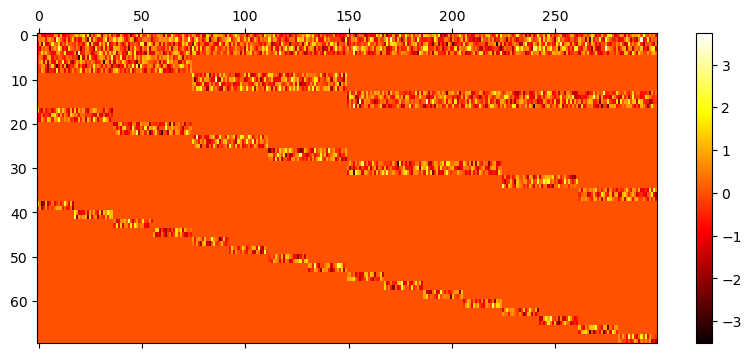

(300, 70)


In [7]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [8]:
type(true_sparse_F)

numpy.ndarray

In [9]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [10]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [11]:
for level_A in range(len(F_hpart["lk"])): 
    for level_B in range(level_A+1):
        lk_A = F_hpart['lk'][level_A]
        lk_B = F_hpart['lk'][level_B]
        A = true_compressed_F[:,ranks[:level_A].sum():ranks[:level_A+1].sum()]
        B = true_compressed_F[:,ranks[:level_B].sum():ranks[:level_B+1].sum()]
        
        AtB = mfm.block_diag_lk(lk_A, A).T @  mfm.block_diag_lk(lk_B, B)
        res = mfm.mult_blockdiag_refined_AtB(A, lk_A, B, lk_B)
        # res2 = jit_mult_blockdiag_refined_AtB(A, lk_A, B, lk_B)
        # indices of groups in A that refine groups in B
        indices_A2B = np.searchsorted(lk_A, lk_B, side='left') * ranks[level_A]
        assert np.allclose(AtB, mfm.block_diag_lk(indices_A2B, res)) 
        # assert np.allclose(AtB, block_diag_lk(indices_A2B, res2))

        AAt = mfm.block_diag_FFt(level_A, F_hpart, A)
        assert np.allclose(AAt, mfm.block_diag_AB(lk_A, A, A.T)) and np.allclose(AAt, mfm.block_diag_lk(lk_A, A) @ mfm.block_diag_lk(lk_A, A).T)

print("PASSED")

PASSED


In [12]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0


In [13]:
for _ in range(20):
    v = np.random.randn(n)
    
    prev_l_recurrence = (1/D[:, np.newaxis]) * np.concatenate([v[:, np.newaxis], F_Lm1], axis=1)

    size_v_F_l = np.array([F_hpart["lk"][l].size-1 for l in range(L-1)]) * ranks[:-1]
    size_v_F_l[0] += 1
    sparse_v_F_lm1 = np.concatenate([v[:, np.newaxis], true_sparse_F], axis=1)
    sparse_prev_l_recurrence = (1/D[:, np.newaxis]) * sparse_v_F_lm1
    assert np.allclose(np.diag(1/D) @ true_compressed_F, prev_l_recurrence[:, 1:])
    assert np.allclose(sparse_prev_l_recurrence, mfm.inv_rec_term_to_sparse(prev_l_recurrence, F_hpart["lk"], ranks))

    for level in reversed(range(1, L-1)):
        pl = F_hpart['lk'][level].size - 1
        rl = ranks[level]
        assert prev_l_recurrence.shape == (n, 1 + ranks[:level+1].sum())
        assert np.allclose(sparse_prev_l_recurrence, mfm.inv_rec_term_to_sparse(prev_l_recurrence, F_hpart["lk"][:level+1], ranks[:level+1]))
        # M0 same sparsity as Fl
        M0 = prev_l_recurrence[:, -ranks[level]:]

        # M1 = M0.T @ rec_term, same sparsity as rec_term
        M1 = np.zeros((rl * pl, 1 + ranks[:level].sum()))
        for lp in range(level):
            if lp == 0:
                M1[:, :1] = mfm.mult_blockdiag_refined_AtB(M0, 
                                                        F_hpart['lk'][level], 
                                                        v.reshape(-1, 1), 
                                                        F_hpart['lk'][lp])
            M1[:, 1+ranks[:lp].sum() : 1+ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AtB(M0, 
                                                                                F_hpart['lk'][level], 
                                                                                F_Lm1[:, ranks[:lp].sum():ranks[:lp+1].sum()], 
                                                                                F_hpart['lk'][lp])
        # check M1 computation
        sparse_M0 = sparse_prev_l_recurrence[:, size_v_F_l[:level].sum():size_v_F_l[:level+1].sum()]
        sparse_M1 = sparse_M0.T @ sparse_v_F_lm1[:, :size_v_F_l[:level].sum()]
        M1_lks = [np.searchsorted(F_hpart['lk'][level], lk_B, side='left') * rl for lk_B in F_hpart['lk'][:level]]
        assert np.allclose(sparse_M1, mfm.inv_rec_term_to_sparse(M1, M1_lks, ranks[:level]))
        # del sparse_M0, sparse_M1


        # M2 = (I + Fl^T M0)^{-1}, blockdiagonal with pl blocks of size (rl x rl)
        FlTM0 = mfm.mult_blockdiag_refined_AtB(F_Lm1[:, ranks[:level].sum() : ranks[:level+1].sum()], 
                                        F_hpart['lk'][level], 
                                        M0, 
                                        F_hpart['lk'][level])
        # check Fl^TM0 computation
        sparse_FlTM0 = sparse_v_F_lm1[:, size_v_F_l[:level].sum():size_v_F_l[:level+1].sum()].T @ sparse_M0
        assert np.allclose(sparse_FlTM0, mfm.block_diag_lk(np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), FlTM0))
        M2 = np.zeros((pl*rl, rl))
        for k in range(pl):
            np.fill_diagonal(FlTM0[k*rl : (k+1)*rl], FlTM0[k*rl : (k+1)*rl].diagonal() + 1)
            M2[k*rl : (k+1)*rl] = pinvh(FlTM0[k*rl : (k+1)*rl])
        # check M2 computation, symmetric PD matrix
        sparse_M2 = np.linalg.inv(np.eye(rl*pl) + sparse_FlTM0)
        assert np.allclose(sparse_M2, mfm.block_diag_lk(np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), M2))


        # M3 = M2 @ M1, same sparsity as M1
        M3 = np.zeros((rl * pl, 1 + ranks[:level].sum()))
        for lp in range(level):
            if lp == 0:
                M3[:, :1] = mfm.mult_blockdiag_refined_AtB(M2, 
                                                        np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), 
                                                        M1[:, :1], 
                                                        M1_lks[lp])
            M3[:, 1+ranks[:lp].sum():1+ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AtB(M2, 
                                                                                        np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), 
                                                                                        M1[:,1+ranks[:lp].sum():1+ranks[:lp+1].sum()], 
                                                                                        M1_lks[lp])
        # check M3 computation
        sparse_M3 = sparse_M2 @ sparse_M1
        assert np.allclose(sparse_M3, mfm.inv_rec_term_to_sparse(M3, M1_lks, ranks[:level]))


        # M4 = M0 @ M3, same sparsity as current rec_term
        M4 = np.zeros((n, 1 + ranks[:level].sum()))
        for lp in range(level):
            if lp == 0:
                M4[:, :1] = mfm.mult_blockdiag_refined_AB(M0, 
                                                        F_hpart["lk"][level], 
                                                        M3[:, :1], 
                                                        M1_lks[lp])
            M4[:, 1+ranks[:lp].sum() : 1+ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AB(M0, 
                                                                                        F_hpart["lk"][level], 
                                                                                        M3[:,1+ranks[:lp].sum():1+ranks[:lp+1].sum()], 
                                                                                        M1_lks[lp])
        # check M4 computation
        sparse_M4 = sparse_M0 @ sparse_M3
        assert np.allclose(sparse_M4, mfm.inv_rec_term_to_sparse(M4, F_hpart["lk"][:level], ranks[:level]))


        # M5 
        prev_l_recurrence = prev_l_recurrence[:, :1+ranks[:level].sum()] - M4
        # check M5 computation
        sparse_prev_l_recurrence = sparse_prev_l_recurrence[:, :size_v_F_l[:level].sum()] - sparse_M4
        assert np.allclose(sparse_prev_l_recurrence, mfm.inv_rec_term_to_sparse(prev_l_recurrence, F_hpart["lk"][:level], ranks[:level]))
        

    # final level=0 
    level = 0
    pl = F_hpart['lk'][level].size - 1
    rl = ranks[level]
    assert prev_l_recurrence.shape == (n, 1 + ranks[:level+1].sum())
    assert np.allclose(sparse_prev_l_recurrence, mfm.inv_rec_term_to_sparse(prev_l_recurrence, F_hpart["lk"][:level+1], ranks[:level+1]))
    # M0 same sparsity as Fl
    M0 = prev_l_recurrence[:, -ranks[level]:]

    # M1 = M0.T @ rec_term, same sparsity as rec_term
    M1 = mfm.mult_blockdiag_refined_AtB(M0, 
                                    F_hpart['lk'][level], 
                                    v[:, np.newaxis], 
                                    F_hpart['lk'][0])
    # check M1 computation
    sparse_M0 = sparse_prev_l_recurrence[:, 1:size_v_F_l[:level+1].sum()]
    sparse_M1 = sparse_M0.T @ v[:, np.newaxis] 
    assert np.allclose(sparse_M1, M1)
    # del sparse_M0, sparse_M1


    # M2 = (I + Fl^T M0)^{-1}, blockdiagonal with pl blocks of size (rl x rl)
    FlTM0 = mfm.mult_blockdiag_refined_AtB(F_Lm1[:, :ranks[:level+1].sum()], 
                                        F_hpart['lk'][level], 
                                        M0, 
                                        F_hpart['lk'][level])
    # check Fl^TM0 computation
    sparse_FlTM0 = sparse_v_F_lm1[:, 1:size_v_F_l[:level+1].sum()].T @ sparse_M0
    assert np.allclose(sparse_FlTM0, FlTM0)
    M2 = pinvh(np.eye(rl) + FlTM0)
    # check M2 computation, symmetric PD matrix
    sparse_M2 = np.linalg.inv(np.eye(rl*pl) + sparse_FlTM0)
    assert np.allclose(sparse_M2, M2)


    # M3 = M2 @ M1, same sparsity as M1
    M3 = M2 @ M1
    # check M3 computation
    sparse_M3 = sparse_M2 @ sparse_M1
    assert np.allclose(sparse_M3, M3)


    # M4 = M0 @ M3, same sparsity as current rec_term
    M4 = M0 @ M3
    # check M4 computation
    sparse_M4 = sparse_M0 @ sparse_M3
    assert np.allclose(sparse_M4, M4)


    # M5 
    prev_l_recurrence = prev_l_recurrence[:, :1] - M4
    # check M5 computation
    sparse_prev_l_recurrence = sparse_prev_l_recurrence[:, :size_v_F_l[:level].sum()] - sparse_M4
    assert np.allclose(sparse_prev_l_recurrence, prev_l_recurrence)

    reldiff = np.linalg.norm(prev_l_recurrence - np.linalg.inv(true_sparse_F @ true_sparse_F.T + \
                np.diag(true_D_noise)) @ v[:, np.newaxis]) / np.linalg.norm(v)
    assert reldiff < 1e-9
    print(f"PASSED, {reldiff=}")

PASSED, reldiff=4.164322198094592e-15
PASSED, reldiff=3.849558351410064e-15
PASSED, reldiff=5.219637573975153e-15
PASSED, reldiff=4.363888681588944e-15
PASSED, reldiff=4.19776863546995e-15
PASSED, reldiff=3.7202970168284974e-15
PASSED, reldiff=3.797851158459598e-15
PASSED, reldiff=4.763451828025915e-15
PASSED, reldiff=3.218851907906709e-15
PASSED, reldiff=4.210869689409046e-15
PASSED, reldiff=4.681862133991525e-15
PASSED, reldiff=3.716623073311651e-15
PASSED, reldiff=3.6470666749401705e-15
PASSED, reldiff=2.617028826430471e-15
PASSED, reldiff=3.636283163972599e-15
PASSED, reldiff=2.9587827543492113e-15
PASSED, reldiff=4.70258506240906e-15
PASSED, reldiff=5.264081746278848e-15
PASSED, reldiff=6.54293416760974e-15
PASSED, reldiff=3.901688375972077e-15
